### ***Vasily Mosin***

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc
import itertools
import numpy as np
from skimage import color

### 1. Dataset Preparation

In [2]:
def open_picture(f):
    name = f.readline()
    face_num = int(f.readline().rsplit()[0])
    major_axis_radius = list()
    minor_axis_radius = list()
    center_x = list()
    center_y = list()
    for i in range(face_num):
        features = f.readline().rsplit()
        major_axis_radius.append(float(features[0]))
        minor_axis_radius.append(float(features[1]))
        center_x.append(float(features[4]))
        center_y.append(float(features[3]))
    bbox = list()
    for i in range(face_num):
        bbox.append([center_x[i] - major_axis_radius[i], center_y[i] - minor_axis_radius[i],
                   center_x[i] + major_axis_radius[i], center_y[i] + minor_axis_radius[i]])
    pic = scipy.misc.imread('originalPics/'+name.rstrip()+'.jpg', flatten=False)
    pic = color.rgb2gray(pic)
    return pic, bbox, face_num

In [3]:
f = open('FDDB-folds/FDDB-fold-01-ellipseList.txt')
pic, bbox, face_num = open_picture(f)

In [4]:
def read_picture(pic, bbox, face_num, pixels_per_patch=64):
    croppy = list()
    labels = list()
    size = pixels_per_patch
    w, h = pic.shape
    w = w / size
    h = h / size
    for i in range(w):
        for j in range(h):
            flag = False
            croppy.append(pic[i*size:(i+1)*size,j*size:(j+1)*size])
            for k in range(face_num):
                if((((float(i*size)>bbox[k][0])and(float((i+1)*size)<bbox[k][2])) or
                    ((float(i*size)<bbox[k][0])and(float((i+1)*size)>bbox[k][2])) or
                    ((float((i+1)*size)>bbox[k][0])and(float((i+1)*size)<bbox[k][2])) or 
                    ((float(i*size)>bbox[k][0])and(float(i*size)<bbox[k][2]))) and
                   ((((float(j*size)>bbox[k][1])and(float((j+1)*size)<bbox[k][3])))or 
                     ((float(j*size)<bbox[k][1])and(float((j+1)*size)>bbox[k][3])) or
                     ((float((j+1)*size)>bbox[k][1])and(float((j+1)*size)<bbox[k][3])) or 
                     ((float(j*size)>bbox[k][1])and(float(j*size)<bbox[k][3])))):
                    flag = True
                    labels.append(1)
                    break
            if(not flag):
                labels.append(-1)
    return croppy, labels

In [5]:
croppy, labels = read_picture(pic, bbox, face_num, pixels_per_patch=32)

In [6]:
def plot_picture(pic, croppy, labels, pixels_per_patch=64):
    size = pixels_per_patch
    w, h = pic.shape
    w = w / size
    h = h / size
    fig, ax = plt.subplots(w, h, figsize=(3,3))
    for i in range(w):
        for j in range(h):
            if(labels[i*h+j]==1):
                ax[i,j].imshow(croppy[i*h+j])
            else:
                ax[i,j].imshow(croppy[i*h+j], cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0)
            ax[i,j].axis('off')

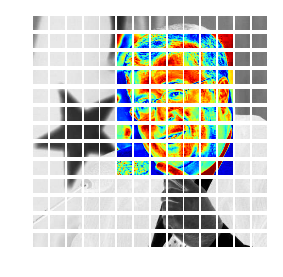

In [7]:
plot_picture(pic, croppy, labels, 32)
f.close()

In [8]:
def generate_data(fold):
    f = open('FDDB-folds/FDDB-fold-'+fold+'.txt')
    num_lines = sum(1 for line in f)
    f.close()
    f = open('FDDB-folds/FDDB-fold-'+fold+'-ellipseList.txt')
    X_train = list()
    y_train = list()
    for i in range(num_lines):
        pic, bbox, face_num = open_picture(f)
        croppy, labels = read_picture(pic, bbox, face_num, pixels_per_patch=32)
        for crop in croppy:
            X_train.append(crop)
        for label in labels:
            y_train.append(label)
    f.close()
    w = np.full(len(y_train), 1.0 / len(y_train), dtype='float32')
    return np.array(X_train), np.array(y_train, dtype='int8'), w

In [9]:
X, y, w = generate_data('01')
X_test, y_test, w_test = generate_data('02')
print X.shape, y.shape, w.shape
print X.dtype, y.dtype, w.dtype

(39830, 32, 32) (39830,) (39830,)
float64 int8 float32


In [10]:
X_ii = np.cumsum(np.cumsum(X, axis=1), axis=2)
X_test_ii = np.cumsum(np.cumsum(X_test, axis=1), axis=2)

### 2. Training AdaBoost

In [11]:
def haar_conv(ii, filters):
    S = (filters[:, 1, 0] - filters[:, 0, 0]) * (filters[:, 1, 1] - filters[:, 0, 1])
    conv = ii[:, filters[:, 1, 0], filters[:, 1, 1]] - \
           ii[:, filters[:, 0, 0], filters[:, 1, 1]] - \
           ii[:, filters[:, 1, 0], filters[:, 0, 1]] + \
           ii[:, filters[:, 0, 0], filters[:, 0, 1]]
    return conv / S

In [12]:
def exp_loss(f, y, sample_weights):
    return sample_weights * np.exp(-f * y)

In [13]:
def generate_random_filters(n, width, height):
    filters = np.zeros(shape=(n, 2, 2), dtype='int32')
    filters[:, 0, 0] = np.random.randint(0, width-1, size=n)
    filters[:, 0, 1] = np.random.randint(0, height-1, size=n)
    delta_x = width - filters[:, 0, 0] - 1
    delta_y = height - filters[:, 0, 1] - 1
    filters[:, 1, 0] = filters[:, 0, 0] + np.floor(np.random.uniform(size=n) * delta_x).astype('int32') + 1
    filters[:, 1, 1] = filters[:, 0, 1] + np.floor(np.random.uniform(size=n) * delta_y).astype('int32') + 1
    return filters

In [14]:
def classifiers_scores(X, filters, threshold, neg, pos):
    conv = haar_conv(X, filters)
    return np.where(conv > threshold, pos, neg)

In [15]:
def fit_classifiers(filters, X, y, w, C = 1.0e-1, subset=None):
    if subset is not None:
        n = int(subset * X.shape[0])
        train_indx = np.random.choice(X.shape[0], size=n, replace=False)
        X = X[train_indx]
        y = y[train_indx]
        w = w[train_indx]
    conv = haar_conv(X, filters)
    indx = np.argsort(conv, axis=0)
    id_filter_selection = np.arange(conv.shape[1])
    tn = np.cumsum((y[indx] == -1) * w[indx], axis=0)
    fn = np.cumsum((y[indx] == 1) * w[indx], axis=0)
    r_indx = indx[::-1, :]
    tp = np.cumsum((y[r_indx] == 1) * w[r_indx], axis=0)[::-1, :]
    fp = np.cumsum((y[r_indx] == -1) * w[r_indx], axis=0)[::-1, :]
    loss = 2 * (np.sqrt(tp * fp) + np.sqrt(tn * fn))
    optimal_threshold_index = np.argmin(loss, axis=0)
    thr_optimal = conv[indx[optimal_threshold_index, id_filter_selection], id_filter_selection]
    tp_optimal = tp[optimal_threshold_index, id_filter_selection]
    tn_optimal = tn[optimal_threshold_index, id_filter_selection]
    fp_optimal = fp[optimal_threshold_index, id_filter_selection]
    fn_optimal = fn[optimal_threshold_index, id_filter_selection]
    neg_vote = -np.log((tn_optimal + C) / (fn_optimal + C)) / 2
    pos_vote = np.log((tp_optimal + C) / (fp_optimal + C)) / 2
    # minimal_loss = loss[optimal_threshold_index, id_filter_selection]
    scores = np.where(conv > thr_optimal, pos_vote, neg_vote)
    ### Due to discrete nature of this filters
    ### sometimes estimated loss is actually much lower than actual one.
    ### Usually it happens when all scores of filter are zeros.
    actual_loss = np.sum(np.exp(-scores * y[:, None]) * w[:, None], axis=0)
    return thr_optimal, neg_vote, pos_vote, actual_loss

In [16]:
filters = generate_random_filters(2**8, 32, 32)

In [17]:
%%time

thr, neg, pos, loss = fit_classifiers(filters, X_ii, y, w)

CPU times: user 6.55 s, sys: 700 ms, total: 7.25 s
Wall time: 7.58 s


In [18]:
class HaarBoost(object):
    def __init__(self, n_filters = 32, n_selection=256, train_subset = 0.1, C = 1.0, learning_rate = 1.0):
        self.n_filters = n_filters
        self.n_selection = n_selection
        self.train_subset = train_subset
        self.C = C
        self.ensemble_filters = np.zeros(shape=(n_filters, 2, 2), dtype='int32')
        self.ensemble_threshold = np.zeros(shape=n_filters, dtype='float32')
        self.ensemble_pos = np.zeros(shape=n_filters, dtype='float32')
        self.ensemble_neg = np.zeros(shape=n_filters, dtype='float32')
        self.learning_rate = learning_rate
    
    def select_filter(self, X, y, w):
        random_filters = generate_random_filters(self.n_selection, X.shape[1], X.shape[2])
        thrs, negs, poss, losses = fit_classifiers(random_filters, X, y, w, C=self.C, subset=self.train_subset)
        best = np.argmin(losses)
        return random_filters[best], thrs[best], negs[best], poss[best], losses[best]
    
    def ensemble_staged_score(self, X):
        scores = classifiers_scores(X, self.ensemble_filters, self.ensemble_threshold,
                                    self.ensemble_neg, self.ensemble_pos)
        return np.cumsum(scores, axis=1)

    def ensemble_score(self, X):
        scores = classifiers_scores(X, self.ensemble_filters, self.ensemble_threshold,
                                    self.ensemble_neg, self.ensemble_pos)
        return np.sum(scores, axis=1)
    
    def fit(self, X, y, sample_weights=None):
        self.ensemble_pos[:] = 0.0
        self.ensemble_neg[:] = 0.0
        self.ensemble_threshold[:] = 0.0
        train_curve = np.zeros(shape=self.n_filters)
        i = 0
        miss_step = 0
        n_max_miss_step = 10
        start_time = 0.0
        end_time = 0.0
        while i < self.n_filters:
            ensemble_scores = self.ensemble_score(X)
            ensemble_losses = exp_loss(ensemble_scores, y, sample_weights)
            ensemble_loss = np.sum(ensemble_losses)
            filter, thr, neg, pos, loss = self.select_filter(X, y, ensemble_losses)
            if loss < ensemble_loss:
                self.ensemble_filters[i] = filter
                self.ensemble_threshold[i] = thr
                self.ensemble_neg[i] = neg * self.learning_rate
                self.ensemble_pos[i] = pos * self.learning_rate
                train_curve[i] = ensemble_loss
                i += 1
                miss_step = 0
                if i % 5 == 0:
                    print '%d classfier selected' % i
            elif miss_step >= n_max_miss_step:
                print 'Early stopping, no candidates for %d steps' % miss_step
                break
            else:
                print 'No candidate for classifier %d (try %d)' % (i, miss_step)
                miss_step += 1
        return train_curve
        
    def predict(self, X):
        return self.ensemble_score(X)
    
    def staged_predict(self, X):
        return self.ensemble_staged_score(X)

In [19]:
clf = HaarBoost(n_filters=100, n_selection=256, train_subset=1.0, C=1.0e-3, learning_rate=1.0)

In [20]:
%%time

losses = clf.fit(X_ii, y, sample_weights=w)

/home/vasiliy/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide
/home/vasiliy/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


5 classfier selected
10 classfier selected
15 classfier selected
20 classfier selected
25 classfier selected
30 classfier selected
35 classfier selected
40 classfier selected
45 classfier selected
50 classfier selected
55 classfier selected
60 classfier selected
65 classfier selected
70 classfier selected
75 classfier selected
80 classfier selected
85 classfier selected
90 classfier selected
95 classfier selected
100 classfier selected
CPU times: user 11min 33s, sys: 1min 15s, total: 12min 49s
Wall time: 12min 58s


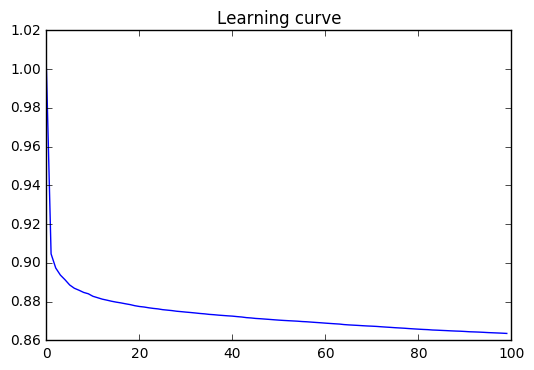

In [21]:
plt.title("Learning curve")
plt.plot(losses)

### 3. Training Cascade

In [69]:
def haar_conv_train(ii, filters):
    S = (filters[1, 0] - filters[0, 0]) * (filters[1, 1] - filters[0, 1])
    conv = ii[:, filters[1, 0], filters[1, 1]] - \
           ii[:, filters[0, 0], filters[1, 1]] - \
           ii[:, filters[1, 0], filters[0, 1]] + \
           ii[:, filters[0, 0], filters[0, 1]]
    return conv / S

def classifiers_scores_train(X, filters, thresholds):
    conv = haar_conv_train(X, filters)
    return np.where(conv > thresholds, 1, -1)

In [70]:
from sklearn.metrics import precision_recall_curve, confusion_matrix
X_train = X_ii
y_true = y
thresses = []
fnr = []
fpr = []
for i in range(clf.n_filters):
    y_scores = haar_conv_train(X_train, clf.ensemble_filters[i])
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    false_nefative_rate = 1 - recall
    threshold = thresholds[np.where(false_nefative_rate < 0.01*np.exp(i/32.0))[0]][-1]
    y_pred = classifiers_scores_train(X_train, clf.ensemble_filters[i], threshold)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr.append(float(fp) / (fp + tn))
    fnr.append(float(fn) / (fn + tp))
    thresses.append(threshold)
    rejected = np.where(y_scores < threshold)[0]
    y_true = np.delete(y_true, rejected)
    X_train = np.delete(X_train, rejected, axis=0)

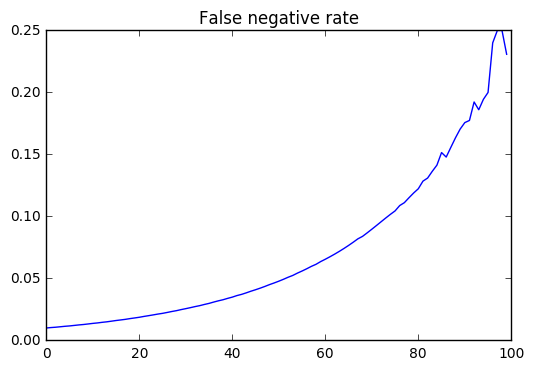

In [84]:
plt.title("False negative rate")
plt.plot(fnr)

### 4. Analysis of Cascades Behavior

In [82]:
def haar_conv_test(ii, filters):
    S = (filters[1, 0] - filters[0, 0]) * (filters[1, 1] - filters[0, 1])
    conv = ii[filters[1, 0], filters[1, 1]] - \
           ii[filters[0, 0], filters[1, 1]] - \
           ii[filters[1, 0], filters[0, 1]] + \
           ii[filters[0, 0], filters[0, 1]]
    return conv / S

def classifiers_scores_test(X, filters, thresholds):
    conv = haar_conv_test(X, filters)
    if(conv > thresholds):
        return 1
    else:
        return -1

In [89]:
negative_samples = np.where(y_test == -1)[0]
X_negative_test = X_test_ii[negative_samples]
stages = np.zeros(len(negative_samples), dtype=int)
for i in range(len(negative_samples)):
    for j in range(clf.n_filters):
        if(classifiers_scores_test(X_negative_test[i], clf.ensemble_filters[j], thresses[j]) == 1):
            stages[i] = stages[i] + 1
        else:
            break

(array([ 671.,  473.,  521.,  492.,  428.,  322.,  758.,  347.,  350.,
         808.,  265.,  326.,  304.,  326.,  595.,  332.,  792.,  303.,
         375.,  329.,  606.,  651.,  268.,  271.,  436.,  333.,  779.,
         293.,  273.,  293.,  290.,  285.,  394.,  703.,  276.,  208.,
         233.,  616.,  196.,  241.,  263.,  243.,  314.,  294.,  233.,
         355.,  231.,  177.,  232.,  207.,  294.,  228.,  224.,  258.,
         196.,  169.,  182.,  181.,  209.,  176.,  133.,  195.,  114.,
         192.,  163.,  130.,  196.,  148.,  216.,  239.,  312.,  142.,
         222.,  249.,  134.,  212.,  267.,  150.,  123.,  335.,  385.,
         473.,   55.,   50.,   24.,   18.,   20.,    4.,    8.,    4.,
           5.,    6.,    4.,    1.,    7.,    3.,    2.,    4.,    2.,   20.]),
 array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
           9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
          18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26

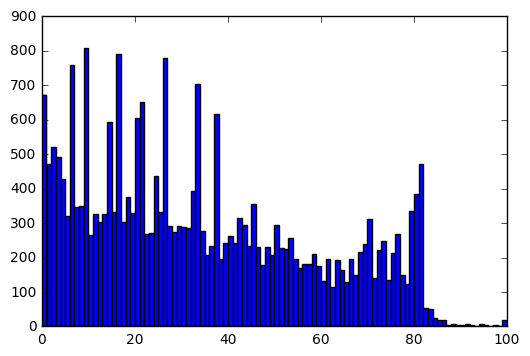

In [93]:
plt.hist(stages,bins=100)

In [251]:
from sklearn.metrics import confusion_matrix
y_true = y_test
X = X_test_ii
fpr = []
fnr = []
for i in range(clf.n_filters):
    y_pred = classifiers_scores_test(X, clf.ensemble_filters[i], thresses[i])
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr.append(float(fn) / (fn + tp))
    fpr.append(float(fp) / (fp + tn))
    rejected = np.where(y_pred == -1)[0]
    y_true = np.delete(y_true, rejected)
    X = np.delete(X, rejected, axis=0)

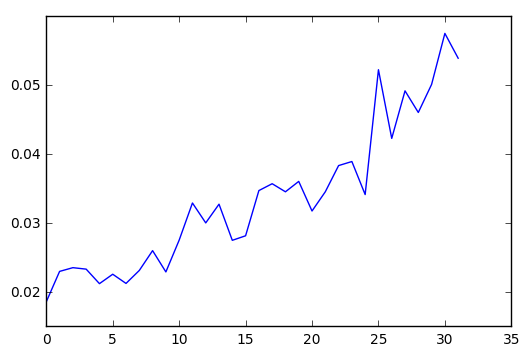

In [254]:
plt.plot(fnr)

In [258]:
from sklearn.metrics import precision_recall_curve
pres = []
rec = []
thrs = []
for i in range(clf.n_filters):
    y_true = y_test
    X = X_test_ii
    y_scores = np.zeros(len(y_true))
    for j in range(i-1):
        y_scores[np.where(classifiers_scores_test(X, clf.ensemble_filters[j], thresses[j])==-1)] = -1
        rejected = np.where(y_scores == -1)[0]
        y_true = np.delete(y_true, rejected)
        X = np.delete(X, rejected, axis=0)
    y_scores[np.where(y_scores==0)] = classifiers_scores_test(X, clf.ensemble_filters[i-1], thresses[i-1])
    y_true = y_test
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    pres.append(precision)
    rec.append(recall)
    thrs.append(thresholds)

/home/vasiliy/.local/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


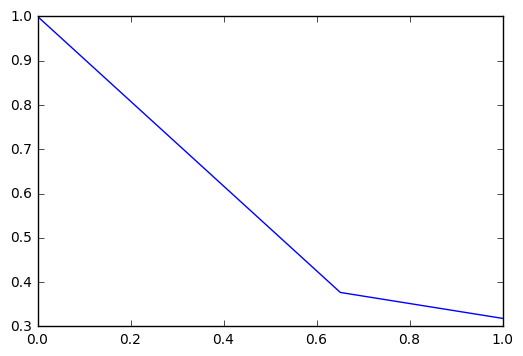

In [264]:
plt.plot(rec[0], pres[0])